# 1- Import Libraries & Setup Kernel

In [1]:
# Librerías de Dataset y procesamiento
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Librerías para plotear
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Configuración de Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Librerías ML 
from sklearn.cluster import KMeans

# 2- Import & Explore


In [2]:
# Crear un DataFrame llamado "data" para importar el CSV
data = pd.read_csv('../data/OnlineRetail-02.csv')

# Convertir InvoiceDate a formato fecha
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [3]:
data.head()

,CustomerID,Country,InvoiceNo,InvoiceDate,Description,Quantity,UnitPrice,TotalPrice,FirstInvoice,InvoiceYear,InvoiceMonth,InvoiceWeekYear,InvoiceDayYear,InvoiceDayWeek,InvoiceHour,InvoiceTimestamp
0,17850.0,United Kingdom,536365,2010-12-01 08:26:00,white hanging heart t-light holder,6,2.55,15.30,1,2010,12,48,335,2,8,1291188360
1,17850.0,United Kingdom,536365,2010-12-01 08:26:00,white metal lantern,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360
2,17850.0,United Kingdom,536365,2010-12-01 08:26:00,cream cupid hearts coat hanger,8,2.75,22.00,1,2010,12,48,335,2,8,1291188360
3,17850.0,United Kingdom,536365,2010-12-01 08:26:00,knitted union flag hot water bottle,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360
4,17850.0,United Kingdom,536365,2010-12-01 08:26:00,red woolly hottie white heart.,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360


# 3- Amount of New Customers by Months

In [4]:
customers_finvoice = data[data.InvoiceYear == 2011].groupby(['InvoiceMonth', 'FirstInvoice']).CustomerID.agg(['nunique']).reset_index()

new_c = customers_finvoice[customers_finvoice.FirstInvoice == 1]
old_c = customers_finvoice[customers_finvoice.FirstInvoice == 0]

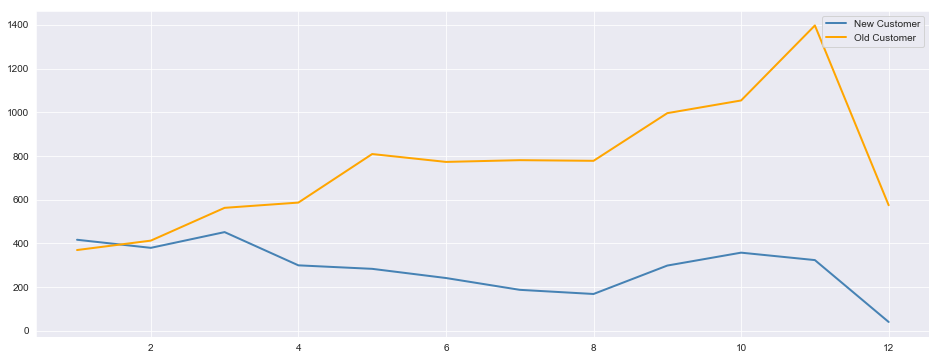

In [5]:
# data['InvoiceYearDAY'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.week)

# insights = pd.pivot_table(data, index=['InvoiceYear','InvoiceYearDAY','FirstInvoice'], 
#                           values=['TotalPrice'], aggfunc={'TotalPrice': np.sum}).reset_index()

plt.figure(figsize=(16, 6))
plt.plot('InvoiceMonth', 'nunique', label='New Customer', 
         data=new_c, color='steelblue', linewidth=2)
plt.plot('InvoiceMonth', 'nunique', label='Old Customer', 
         data=old_c, color='orange', linewidth=2)

plt.legend(loc='upper right')
plt.show()



# 4- RFM Clulsters

In [ ]:
# Make a DF with the last purchase date for each customer
df_customers = data.groupby('CustomerID').InvoiceDate.max().reset_index()
df_customers.columns = ['CustomerID','LastPurchaseDate']

# Calculate inactivity days for each CustomerID
df_customers['Recency'] = (df_customers.LastPurchaseDate.max() - df_customers.LastPurchaseDate).dt.days

In [6]:
model_df = data.groupby('CustomerID').InvoiceDate.min().reset_index()
model_df.columns = ['CustomerID','FirstPurchaseDate']

#Amount of Invoices
model_invoices = data.groupby(['CustomerID','InvoiceNo', 'InvoiceDate']).TotalPrice.agg(['sum']).reset_index()
model_invoices.columns = ['CustomerID','InvoiceNo', 'InvoiceDate', 'Revenue']

model_invoices.head()

,CustomerID,InvoiceNo,InvoiceDate,Revenue
0,12346.0,541431,2011-01-18 10:01:00,77183.60
1,12347.0,537626,2010-12-07 14:57:00,711.79
2,12347.0,542237,2011-01-26 14:30:00,475.39
3,12347.0,549222,2011-04-07 10:43:00,636.25
4,12347.0,556201,2011-06-09 13:01:00,382.52


In [7]:
# Contar dias entre invoices
list_invoices = model_invoices.InvoiceNo
model_invoices['days_firstInvoice'] = 0

for invoice in list_invoices:
    date_invoices = model_invoices.InvoiceDate[model_invoices.InvoiceNo == invoice]
    get_user = float(model_invoices.CustomerID[model_invoices.InvoiceNo == invoice].unique())
    first_purchase = model_invoices.InvoiceDate[model_invoices.CustomerID == get_user].min()
    days = (date_invoices - first_purchase).dt.days
    model_invoices.days_firstInvoice[model_invoices.InvoiceNo == invoice] = days


C:\Users\Chorch\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Chorch\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


---
# Recency (Final)

Function to get the "Recency value" of  customers by each months, and also invert results to determine that high value as the most valuable

**Formula**: (Fisrt_Invoices_Date + 30 days - Last_Inovice_Date)<br>

In [8]:
def recency_1M(customer):
    day = 30
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)

def recency_2M(customer):
    day = 60
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)    
#     return -((finaldate - (last_invoices + timedelta(days=30))).days)

def recency_3M(customer):
    day = 90
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)
#     return -((finaldate - (last_invoices + timedelta(days=60))).days)


def recency_4M(customer):
    day = 120
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)
#     return -((finaldate - (last_invoices + timedelta(days=90))).days)

model_invoices['Recency_1M'] = model_invoices.CustomerID.apply(recency_1M)
model_invoices['Recency_2M'] = model_invoices.CustomerID.apply(recency_2M)
model_invoices['Recency_3M'] = model_invoices.CustomerID.apply(recency_3M)
model_invoices['Recency_4M'] = model_invoices.CustomerID.apply(recency_4M)

---
# Frequency (Final)

Function to get the "Frequency value" of  customers by each months, and also invert results to determine that high value as the most valuable.

**Formula**: -(Days / Amonut of Invoices)

In [9]:
def frequency_1M(customer):
    day = 30
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    if n_invoices == 0:
        return -(round(day / 1))
    else:
        return -(round(day / n_invoices))

def frequency_2M(customer):
    day = 60
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 30)])
    if n_invoices == 0:
        return -(round((day - 30) / 1))
    else:
        return -(round((day - 30) / n_invoices))
    
def frequency_3M(customer):
    day = 90
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 60)])
    if n_invoices == 0:
        return -(round((day - 60) / 1))
    else:
        return -(round((day - 60) / n_invoices))
    
def frequency_4M(customer):
    day = 120
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 90)])
    if n_invoices == 0:
        return -(round((day - 90) / 1))
    else:
        return -(round((day - 90) / n_invoices))
    
model_invoices['Frequency_1M'] = model_invoices.CustomerID.apply(frequency_1M)
model_invoices['Frequency_2M'] = model_invoices.CustomerID.apply(frequency_2M)
model_invoices['Frequency_3M'] = model_invoices.CustomerID.apply(frequency_3M)
model_invoices['Frequency_4M'] = model_invoices.CustomerID.apply(frequency_4M)

---
# Monetary (Final)

Function to get the sum of "Monetary value" of customers by each months.

**Result**: Revenue by each month

In [10]:
def monetary_1M(customer):
    day = 30
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_2M(customer):
    day = 60
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 30)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_3M(customer):
    day = 90
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 60)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_rev(customer):
    day = 180
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

model_invoices['Monetary_1M'] = model_invoices.CustomerID.apply(monetary_1M)
model_invoices['Monetary_2M'] = model_invoices.CustomerID.apply(monetary_2M)
model_invoices['Monetary_3M'] = model_invoices.CustomerID.apply(monetary_3M)
model_invoices['Revenue'] = model_invoices.CustomerID.apply(monetary_rev)


In [11]:
model_invoices.head()

,CustomerID,InvoiceNo,InvoiceDate,Revenue,days_firstInvoice,Recency_1M,Recency_2M,Recency_3M,Recency_4M,Frequency_1M,Frequency_2M,Frequency_3M,Frequency_4M,Monetary_1M,Monetary_2M,Monetary_3M
0,12346.0,541431,2011-01-18 10:01:00,77184,0,-30,-60,-90,-120,-30,-30,-30,-30,77184,0,0
1,12347.0,537626,2010-12-07 14:57:00,1823,0,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
2,12347.0,542237,2011-01-26 14:30:00,1823,49,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
3,12347.0,549222,2011-04-07 10:43:00,1823,120,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
4,12347.0,556201,2011-06-09 13:01:00,1823,183,-30,-10,-40,1,-30,-30,-30,-30,712,475,0


In [12]:
# Crear la base del modelo
rfm_model = pd.pivot_table(
    model_invoices, index='CustomerID', values=['Recency_1M', 'Recency_2M', 'Recency_3M', 'Frequency_1M', 
                                                'Frequency_2M', 'Frequency_3M', 'Monetary_1M', 'Monetary_2M', 
                                                'Monetary_3M','Revenue']).reset_index()

rfm_model.head()

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue
0,12346.0,-30,-30,-30,77184,0,0,-30,-60,-90,77184
1,12347.0,-30,-30,-30,712,475,0,-30,-10,-40,1823
2,12348.0,-30,-30,-30,893,227,0,-30,-20,-50,1487
3,12349.0,-30,-30,-30,1758,0,0,-30,-60,-90,1758
4,12350.0,-30,-30,-30,334,0,0,-30,-60,-90,334


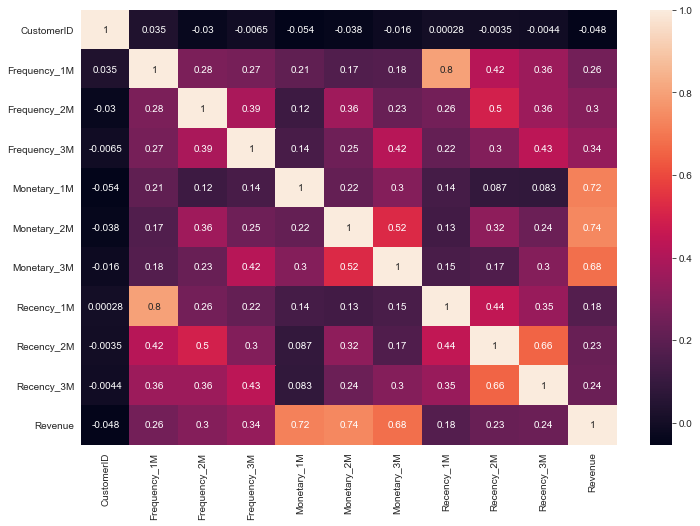

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(rfm_model.corr(), annot=True)
plt.show()

In [ ]:
# Agregar Revenue

# customer_rev = data.groupby(['CustomerID']).TotalPrice.agg(['sum']).reset_index()
# customer_rev.columns = ['CustomerID', 'Revenue']

# customer_rev.head()

---
# Dummies productos

In [ ]:
# Dummies de productos
dummy_product = pd.pivot_table(data, index='CustomerID', values=['Quantity'], columns='Description').reset_index()

In [ ]:
products = dummy_product.Quantity
ids = dummy_product.CustomerID

dummy_product = pd.merge(ids, products, left_index=True, right_index=True)
dummy_product = dummy_product.fillna(0)

dummy_product.shape

In [ ]:
total = dummy_product.isin([0]).sum().reset_index()
total.columns = ['Products', 'Amount']
total = total.sort_values(by='Amount')

dummy_colunms = list(total.Products[:300])
dummy_product = dummy_product[dummy_colunms]
dummy_product.shape

---

In [ ]:
def Q_bins_less(x):
    '''
    Function to create bins by Quartiles
    Function can be used, when the interval most lowest 
    correspond with the value more higher. 
    '''
    quartile = x.quantile([0, 0.25, 0.5, 0.75, 1])
    return pd.cut(np.array(x), quartile, labels=[4, 3, 2, 1])

def Q_bins_more(x):
    '''
    Function to create bins by Quartiles
    Function can be used, when the interval most higher 
    correspond with the value more higher.
    '''
    quartile = x.quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])
    return pd.cut(np.array(x), quartile, labels=[1, 2, 3, 4, 5, 6])

In [ ]:
rfm_customers['RecencyBins'] = Q_bins_less(rfm_customers.Recency)
rfm_customers['FrequencyBins'] = Q_bins_less(rfm_customers.Frequency)
rfm_customers['MonetaryBins'] = Q_bins_more(rfm_customers.Monetary)


rfm_customers['RecencyBins'] = rfm_customers['RecencyBins'].fillna(value=4)
rfm_customers['FrequencyBins'] = rfm_customers['FrequencyBins'].fillna(value=4)
rfm_customers['MonetaryBins'] = rfm_customers['MonetaryBins'].fillna(value=1)

rfm_customers.head()

In [ ]:
def statss(serie, data, title):
    rank = list(serie.unique())
    rank.sort()
    print('\n========', title,'=======\n')
    for e in rank:
        print(':', e, '\n Count:',round(data[serie == e].count()),'\n MIN:'
              ,round(data[serie == e].min()), '\n MAX:',
              round(data[serie == e].max()), '\n')

# statss(rfm_customers.RecencyBins, rfm_customers.Recency, 'Recency')
# statss(rfm_customers.FrequencyBins, rfm_customers.Frequency, 'Frequency')
# statss(rfm_customers.MonetaryBins, rfm_customers.Monetary, 'Monetary')


# Final Dataset

In [ ]:
customer_rev = rfm_model[['CustomerID','Revenue']]
rfm_model = rfm_model.drop(columns='Revenue')

rfm_model.head()

In [ ]:
# WHIT DUMMIES
df_model_f = pd.merge(rfm_model, dummy_product, on='CustomerID')
df_model_f = pd.merge(df_model_f, customer_rev, on='CustomerID')


# WHIT -out DUMMIES
# df_model_f = pd.merge(rfm_model, customer_rev, on='CustomerID')

# df_model_predictor
# dummy_prod
# customer_rev

In [ ]:
df_model_f.head()

In [ ]:
# Create correlation matrix
corr_matrix = df_model_f.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(len(to_drop),'\n', to_drop)

In [ ]:
# Drop features 
df_model_f = df_model_f.drop(df_model_f[to_drop], axis=1)

In [ ]:
# df_model_f['MonetaryBins'] = Q_bins_more(df_model_f.Revenue)


In [ ]:
# Define Train Test
df_train = df_model_f[df_model_f.CustomerID.isin(train_customers)]
df_test = df_model_f[df_model_f.CustomerID.isin(test_customers)]
df_predict = df_model_f[df_model_f.CustomerID.isin(pred_customers)]


# DATA
X_train = df_train.iloc[:,:-1]
# Target
y_train = df_train.iloc[:,-1:]

# DATA
X_test = df_test.iloc[:,:-1]
# Target
y_test = df_test.iloc[:,-1:]




# # Target
# df_train.iloc[:,-1:]

# # DATA
# df_train.iloc[:,:-1]



In [ ]:
df_model_f.head()

# Definicion del Train Test y futuro Predict

In [ ]:
# Crear Dataset con Train-Test y Predicted

# Convertir InvoiceDate a formato fecha
# data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

cut_pred = '2011-09-01'
fin_pred = '2011-09-30'

pred_customers = model_df.CustomerID[(model_df.FirstPurchaseDate >= pd.to_datetime(cut_pred)) & (model_df.FirstPurchaseDate <= pd.to_datetime(fin_pred))]

cut_test = '2011-06-01'
fin_test = '2011-08-31'

test_customers = model_df.CustomerID[(model_df.FirstPurchaseDate >= pd.to_datetime(cut_test)) & (model_df.FirstPurchaseDate <= pd.to_datetime(fin_test))]

cut_train = '2011-05-31'

train_customers = model_df.CustomerID[(model_df.FirstPurchaseDate <= pd.to_datetime(cut_train))]

print('Train:', len(train_customers), '\nTest:', len(test_customers), '\nPredict:', len(pred_customers))


# Make Model by Week (LinearRegression)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [ ]:
ltv_model = LinearRegression()

In [ ]:
ltv_model.fit(X_train, y_train)

In [ ]:
score_training = ltv_model.score(X_train, y_train)
print("Training set score: {:.5f}".format(score_training)) 

score_test = ltv_model.score(X_test, y_test)
print("Test set R^2: {:.5f}".format(score_test))

# Make Model by Week (RandomForestRegressor)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
#Grid search for parameter selection for a Random Forest Classifier model
param_grid = {
    'n_estimators': [100, 200, 300, 400 ],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [25, 20 ,15]
}

In [ ]:
RFR = RandomForestRegressor(n_jobs=-1)
GS = GridSearchCV(RFR, param_grid, cv = 5, verbose = 3)

In [ ]:
GS.fit(X_train, y_train)

In [ ]:
GS.best_params_

In [ ]:
RFR = RandomForestRegressor(max_depth = 15, max_features='auto', n_estimators=200)
RFR.fit(X_train, y_train)

In [ ]:
y_train_pred = RFR.predict(X_train)
y_pred = RFR.predict(X_test)

In [ ]:
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print ('TRAIN MODEL METRICS:')
print('The R2 score is: ' + str(r2))
print('The MAE score is: ' + str(mae))

In [ ]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print ('TEST MODEL METRICS:')
print('The R2 score is: ' + str(r2))
print('The MAE score is: ' + str(mae))

In [ ]:
# ROC